In [1]:
import cv2

In [10]:
input_video_path = "VID (2).mp4" 
output_video_path = "output.mp4"


cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))


fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  
    fg_mask = bg_subtractor.apply(frame)
    fg_mask_colored = cv2.cvtColor(fg_mask, cv2.COLOR_GRAY2BGR)
    out.write(fg_mask_colored)
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Background-subtracted video saved as {output_video_path}")

Background-subtracted video saved as output.mp4


In [2]:
import numpy as np

In [9]:
cap = cv2.VideoCapture("VID (2).mp4")
ret, frame = cap.read()
if not ret:
    print("Error: Couldn't read video")
    cap.release()
    cv2.destroyAllWindows()
    exit()

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
avg_bg = np.float32(gray)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.accumulateWeighted(gray, avg_bg, 0.01)
    bg_model = cv2.convertScaleAbs(avg_bg)
    fg_mask = cv2.absdiff(gray, bg_model)
    _, fg_mask = cv2.threshold(fg_mask, 40, 255, cv2.THRESH_BINARY)
    small_bg_model = cv2.resize(bg_model, (600, 480)) 
    small_fg_mask = cv2.resize(fg_mask, (600, 480))  
    cv2.imshow("Background Model", small_bg_model)
    cv2.imshow("Foreground Mask", small_fg_mask)

    if cv2.waitKey(30) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [6]:
import matplotlib.pyplot as plt


Scene 2 Changed! Waiting for stabilization...
Scene 2 Stabilized! Saving frame...
Total Scenes Detected: 2


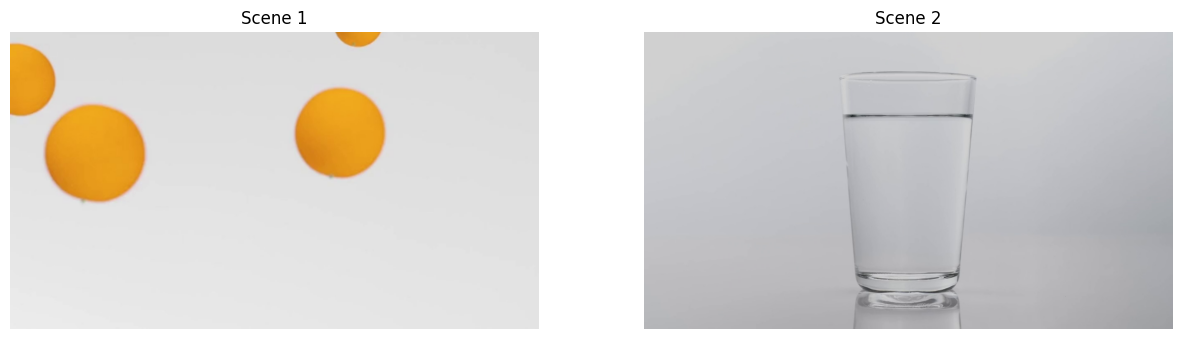

In [8]:
video_path = r"VID (2).mp4"
cap = cv2.VideoCapture(video_path)
fgbg = cv2.createBackgroundSubtractorMOG2()
ret, frame = cap.read()
if not ret:
    print("Error: Couldn't read video")
    cap.release()
    exit()
scenes = [frame.copy()]

prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
prev_hist = cv2.calcHist([prev_gray], [0], None, [256], [0, 256])
cv2.normalize(prev_hist, prev_hist, 0, 1, cv2.NORM_MINMAX)

scene_change_detected = False

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    curr_hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    cv2.normalize(curr_hist, curr_hist, 0, 1, cv2.NORM_MINMAX)
    similarity = cv2.compareHist(prev_hist, curr_hist, cv2.HISTCMP_CORREL)
    fg_mask = fgbg.apply(frame)
    change_ratio = np.count_nonzero(fg_mask) / fg_mask.size
    if similarity < 0.5 and change_ratio > 0.3 and not scene_change_detected:
        print(f"Scene {len(scenes) + 1} Changed! Waiting for stabilization...")
        scene_change_detected = True
    elif scene_change_detected and similarity > 0.9:
        print(f"Scene {len(scenes) + 1} Stabilized! Saving frame...")
        scenes.append(frame.copy())
        scene_change_detected = False 
    prev_hist = curr_hist.copy()

cap.release()
print(f"Total Scenes Detected: {len(scenes)}")
plt.figure(figsize=(15, 5))

for i, scene in enumerate(scenes):
    plt.subplot(1, len(scenes), i + 1)
    plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
    plt.title(f"Scene {i + 1}")
    plt.axis("off")

plt.show()
